In [1]:
import os
os.environ["TF_CPP_MIN_LOG_EVEL"] = "3"


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda import amp

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

from pathlib import Path
from tqdm import tqdm

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cuda


In [4]:
DATA_DIR = Path("/kaggle/input/clean-fer2013plus-dataset")

TRAIN_DIR = DATA_DIR / "train"
TEST_DIR  = DATA_DIR / "test"

print(TRAIN_DIR.exists(), TEST_DIR.exists())

True True


In [5]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2

EPOCHS_STAGE1 = 6
EPOCHS_STAGE2 = 6

In [6]:
weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=weights.transforms().mean,
        std=weights.transforms().std
    )
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=weights.transforms().mean,
        std=weights.transforms().std
    )
])

In [7]:
train_dataset = ImageFolder(TRAIN_DIR, transform=train_transforms)
test_dataset  = ImageFolder(TEST_DIR, transform=test_transforms)

CLASS_NAMES = train_dataset.classes

print("Classes:", CLASS_NAMES)
print("Number of classes:", len(CLASS_NAMES))
print("Train images:", len(train_dataset))
print("Test images :", len(test_dataset))

Classes: ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
Number of classes: 8
Train images: 26642
Test images : 7015


In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

In [10]:
model = convnext_tiny(weights=weights)

# Stage-1: freeze backbone
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier for 8 classes
model.classifier[2] = nn.Linear(
    model.classifier[2].in_features,
    len(CLASS_NAMES)
)

model = model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 189MB/s] 


In [11]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    model.classifier.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

use_amp = DEVICE == "cuda"
scaler = amp.GradScaler(enabled=use_amp)

/tmp/ipykernel_47/3587264745.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler(enabled=use_amp)


In [12]:
def train_one_epoch(model, loader):
    model.train()
    correct, total, loss_sum = 0, 0, 0

    for x, y in tqdm(loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()

        if use_amp:
            with amp.autocast():
                out = model(x)
                loss = criterion(out, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

        loss_sum += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    return loss_sum / total, correct / total


def evaluate(model, loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)

            loss_sum += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    return loss_sum / total, correct / total

In [13]:
for epoch in range(EPOCHS_STAGE1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    te_loss, te_acc = evaluate(model, test_loader)

    print(f"[Stage-1] Epoch {epoch+1} | "
          f"Train Acc={tr_acc:.3f} | Test Acc={te_acc:.3f}")

  0%|          | 0/833 [00:00<?, ?it/s]/tmp/ipykernel_47/3497934555.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 833/833 [01:53<00:00,  7.35it/s]


[Stage-1] Epoch 1 | Train Acc=0.596 | Test Acc=0.648


100%|██████████| 833/833 [01:52<00:00,  7.43it/s]


[Stage-1] Epoch 2 | Train Acc=0.652 | Test Acc=0.664


100%|██████████| 833/833 [01:52<00:00,  7.43it/s]


[Stage-1] Epoch 3 | Train Acc=0.669 | Test Acc=0.672


100%|██████████| 833/833 [01:52<00:00,  7.43it/s]


[Stage-1] Epoch 4 | Train Acc=0.669 | Test Acc=0.664


100%|██████████| 833/833 [01:52<00:00,  7.44it/s]


[Stage-1] Epoch 5 | Train Acc=0.678 | Test Acc=0.680


100%|██████████| 833/833 [01:52<00:00,  7.44it/s]


[Stage-1] Epoch 6 | Train Acc=0.680 | Test Acc=0.659


In [14]:
for param in model.features[-2:].parameters():
    param.requires_grad = True

optimizer = optim.AdamW([
    {"params": model.features[-2:].parameters(), "lr": 1e-5},
    {"params": model.classifier.parameters(), "lr": 1e-4}
])

In [15]:
for epoch in range(EPOCHS_STAGE2):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    te_loss, te_acc = evaluate(model, test_loader)

    print(f"[Stage-2] Epoch {epoch+1} | "
          f"Train Acc={tr_acc:.3f} | Test Acc={te_acc:.3f}")

  0%|          | 0/833 [00:00<?, ?it/s]/tmp/ipykernel_47/3497934555.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 833/833 [04:33<00:00,  3.05it/s]


[Stage-2] Epoch 1 | Train Acc=0.703 | Test Acc=0.709


100%|██████████| 833/833 [04:33<00:00,  3.05it/s]


[Stage-2] Epoch 2 | Train Acc=0.732 | Test Acc=0.735


100%|██████████| 833/833 [04:33<00:00,  3.04it/s]


[Stage-2] Epoch 3 | Train Acc=0.756 | Test Acc=0.746


100%|██████████| 833/833 [04:33<00:00,  3.04it/s]


[Stage-2] Epoch 4 | Train Acc=0.767 | Test Acc=0.756


100%|██████████| 833/833 [04:33<00:00,  3.05it/s]


[Stage-2] Epoch 5 | Train Acc=0.786 | Test Acc=0.760


100%|██████████| 833/833 [04:33<00:00,  3.05it/s]


[Stage-2] Epoch 6 | Train Acc=0.794 | Test Acc=0.759


In [16]:
_, final_acc = evaluate(model, test_loader)
print("🏆 Final Test Accuracy:", final_acc)

🏆 Final Test Accuracy: 0.7588025659301497


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

In [18]:
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [19]:
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print("📊 Evaluation Metrics (Test Set)")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

📊 Evaluation Metrics (Test Set)
Accuracy : 0.7588
Precision: 0.7490
Recall   : 0.7588
F1-score : 0.7478


In [20]:
print("\n📋 Classification Report:\n")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=CLASS_NAMES,
        digits=4
    )
)


📋 Classification Report:

              precision    recall  f1-score   support

       anger     0.7505    0.5950    0.6637       637
    contempt     0.5000    0.0588    0.1053        51
     disgust     0.4286    0.1091    0.1739        55
        fear     0.5607    0.3681    0.4444       163
   happiness     0.7754    0.9218    0.8423      1816
     neutral     0.7793    0.8010    0.7900      2583
     sadness     0.6316    0.4953    0.5552       848
    surprise     0.7876    0.8260    0.8063       862

    accuracy                         0.7588      7015
   macro avg     0.6517    0.5219    0.5476      7015
weighted avg     0.7490    0.7588    0.7478      7015



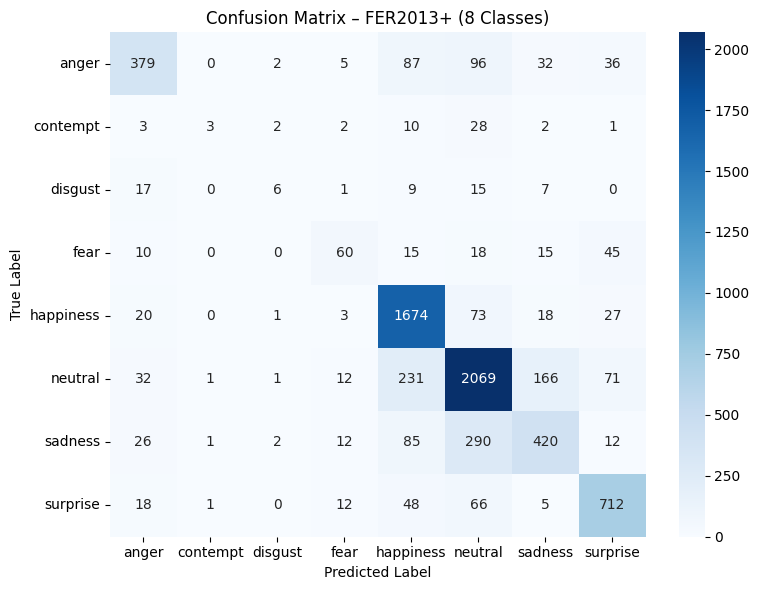

In [21]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – FER2013+ (8 Classes)")
plt.tight_layout()
plt.show()

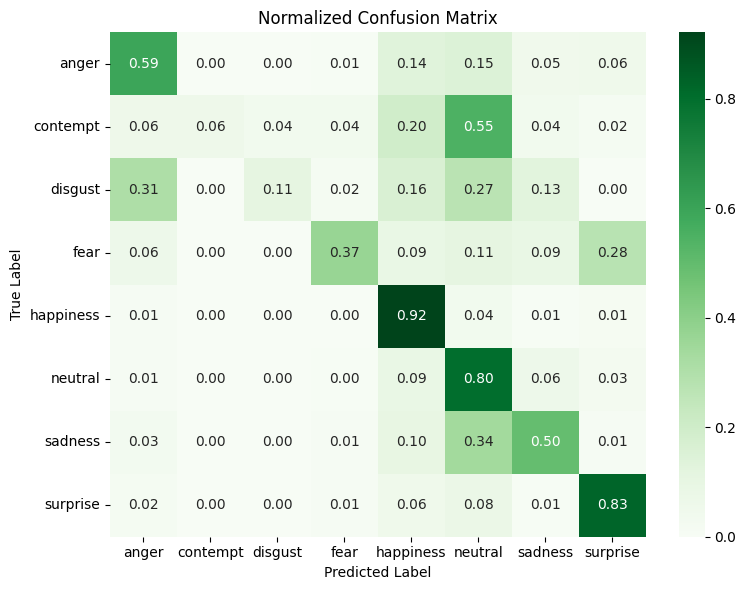

In [22]:
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Greens",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()

In [23]:
torch.save({
    "model_name": "convnext_tiny",
    "model_state_dict": model.state_dict(),
    "class_names": CLASS_NAMES,
    "img_size": IMG_SIZE
}, "best_model_convnext_clean.pth")

print("✅ Model saved successfully")

✅ Model saved successfully
